In [1]:
# Utilities
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# Tuning
from sklearn.model_selection import GridSearchCV

# Multioutput
from sklearn.multioutput import MultiOutputRegressor as MOR

# Scoring
from sklearn.metrics import mean_squared_error

# Model Persistence
from joblib import dump, load

In [2]:
# Data loading
df = pd.read_csv('../../train_with_zip_pop_weather825000.csv')
df_sub = df.sample(n=1500)

features = ["Hour", "Weekend", "Month", "radius_in_miles", "population", 
            "population_density", "land_area_in_sqmi", "water_area_in_sqmi", 
            "housing_units", "occupied_housing_units", "median_home_value", 
            "median_household_income", "temp", "dwpt", "rhum", "prcp", 
            "wdir", "wspd", "pres", "coco"]

percentiles = ['p20', 'p40', 'p50', 'p60', 'p80']
targets = [f"TotalTimeStopped_{percentile}" for percentile in percentiles]
targets_sub = [f"TotalTimeStopped_p60"]

X = df[features]
y = df[targets]

X_selection = df_sub[features]
y_selection = df_sub[targets_sub]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [3]:
# Preprocessing
preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),    # All features are numerical
        ("decomposition", PCA())
    ]
)

# Model fitting
def fit_model(model, X, y, grid_search=True):
    print(f"Fitting {model['regr']}")
    pipe = Pipeline(
        steps=[
            ('preprocess', preprocessor),
            ('regression', MOR(model['regr']))
        ]
    )
    param_grid = model['params']
    
    if grid_search:
        gs = GridSearchCV(estimator=pipe,
                          param_grid=param_grid,
                          cv=3,
                          scoring="neg_root_mean_squared_error",
                          n_jobs=-1,
                          verbose=2
                         )

        gs.fit(X, y)        
        return gs
    else:
        pipe.fit(X, y)
        return pipe

In [4]:
# Models and desired parameters
models = {
    'sgd': {
        'regr': SGDRegressor(),
        'params': {
            'preprocess__decomposition__n_components': [2, 3, 5],
            'regression__estimator__penalty': ["l2", "l1"],
            'regression__estimator__alpha': [.0001, .0005, .001],
            'regression__estimator__learning_rate': ["optimal"],
            'regression__estimator__max_iter': [10000]
        }
    },
    'rfr': {
        'regr': RandomForestRegressor(),
        'params': {
            'preprocess__decomposition__n_components': [2, 3, 5],
            'regression__estimator__n_estimators': [50, 100, 250],
            'regression__estimator__min_samples_leaf': [1, 5, 25]
#             'regression__estimator__max_depth': []
        }
    },
    'gbr': {
        'regr': GradientBoostingRegressor(),
        'params': {
            'preprocess__decomposition__n_components': [2, 3, 5],
            'regression__estimator__learning_rate': [50, 100, 250],
            'regression__estimator__n_estimators': [50, 100, 250] 
        }
    },
    'abr': {
        'regr': AdaBoostRegressor(),
        'params': {
            'preprocess__decomposition__n_components': [2, 3, 5],
            'regression__estimator__learning_rate': [50, 100, 250],
            'regression__estimator__n_estimators': [25, 50, 100]
        }
    }
}

In [5]:
# Model selection and hyperparameter tuning
gs_models = {}
for model in models:
    gs_models[model] = fit_model(models[model], X_selection, y_selection)
    print(f"\nBest score for {models[model]['regr']}: {gs_models[model].best_score_}") 
    print(f"Best parameters for {models[model]['regr']}: {gs_models[model].best_params_}")    
    print('#############################################################')

Fitting SGDRegressor()
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best score for SGDRegressor(): -9.522491140810605e+19
Best parameters for SGDRegressor(): {'preprocess__decomposition__n_components': 3, 'regression__estimator__alpha': 0.001, 'regression__estimator__learning_rate': 'optimal', 'regression__estimator__max_iter': 10000, 'regression__estimator__penalty': 'l1'}
#############################################################
Fitting RandomForestRegressor()
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best score for RandomForestRegressor(): -20.79619638931988
Best parameters for RandomForestRegressor(): {'preprocess__decomposition__n_components': 2, 'regression__estimator__min_samples_leaf': 25, 'regression__estimator__n_estimators': 50}
#############################################################
Fitting GradientBoostingRegressor()
Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\casey\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-1.36183311e+085             -inf              nan -2.55010330e+100
             -inf              nan -2.71135939e+120             -inf
              nan -1.07620312e+085             -inf              nan
 -2.00474659e+100             -inf              nan -2.13922272e+120
             -inf              nan -8.76366701e+084             -inf
              nan -1.63902288e+100             -inf              nan
 -1.74887736e+120             -inf              nan]
  warnings.warn(
C:\Users\casey\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights



Best score for GradientBoostingRegressor(): -8.763667005475094e+84
Best parameters for GradientBoostingRegressor(): {'preprocess__decomposition__n_components': 5, 'regression__estimator__learning_rate': 50, 'regression__estimator__n_estimators': 50}
#############################################################
Fitting AdaBoostRegressor()
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best score for AdaBoostRegressor(): -23.620312296753667
Best parameters for AdaBoostRegressor(): {'preprocess__decomposition__n_components': 2, 'regression__estimator__learning_rate': 100, 'regression__estimator__n_estimators': 50}
#############################################################


In [8]:
'''
Full training, use the same abbreviation used in models dictionary above
for top-level key and maintanin the dictionary structure as shown below
'''
chosen_models = {
    'abr': {
        'regr': None,
        'params': None,
        'model': None,
        'rmse': None
    },
    'rfr': {
        'regr': None,
        'params': None,
        'model': None,
        'rmse': None
    }
}


for model in chosen_models:
    chosen_models[model]['regr'] = models[model]['regr']
    chosen_models[model]['params'] = gs_models[model].best_params_.copy()
    
    chosen_models[model]['model'] = fit_model(chosen_models[model], X_train, y_train, grid_search=False)
    preds = chosen_models[model]['model'].predict(X_test)
    chosen_models[model]['rmse'] = mean_squared_error(y_test, preds)**.5
    
    dump(chosen_models[model], f'./model_cache/{model}.joblib') 
    rmse = chosen_models[model]['rmse']
    print(f'{model} score: {rmse}')

Fitting AdaBoostRegressor()
abr score: 38.366318333020224
Fitting RandomForestRegressor()
rfr score: 18.983529774384063


In [41]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
preds = {}
for model in chosen_models:
    preds[model] = chosen_models[model]['model'].predict(X_test)

In [101]:
def pred_err_plot(model, percentile, n_samples, actual_0=False, color='steelblue'):
    fig,axs = plt.subplots(figsize=(15,7))
    x_ax = np.arange(0, n_samples, 1)
    
    diff = preds[model] - y_test
    if actual_0:    # Predictions where actual value == 0
        axs.bar(x_ax, 
                diff[y_test['TotalTimeStopped_p60'] == 0]['TotalTimeStopped_p60'].sample(n=n_samples), 
                label=model, 
                color=color) 
        axs.set_title(f"{n_samples} samples where predicted-actual where actual value == 0")
    else:
        axs.bar(x_ax, 
                diff['TotalTimeStopped_p60'].sample(n=n_samples), 
                label=model, 
                color=color)
        axs.set_title(f"{n_samples} samples, predicted-actual")

    axs.set_xlabel(f"{n_samples} Samples")
    axs.set_ylabel(f"Prediction Error, {percentile}")
    
    axs.grid("on")
    axs.legend()
    plt.show()

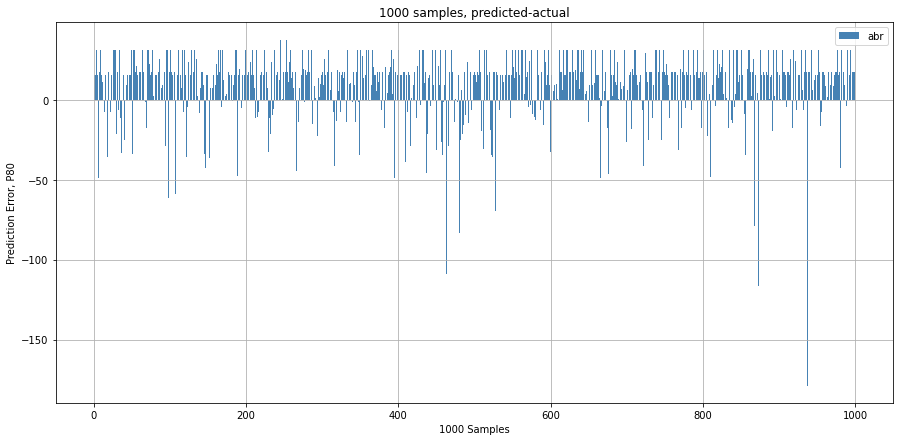

In [102]:
pred_err_plot(model='abr', percentile='P80', n_samples=1000)

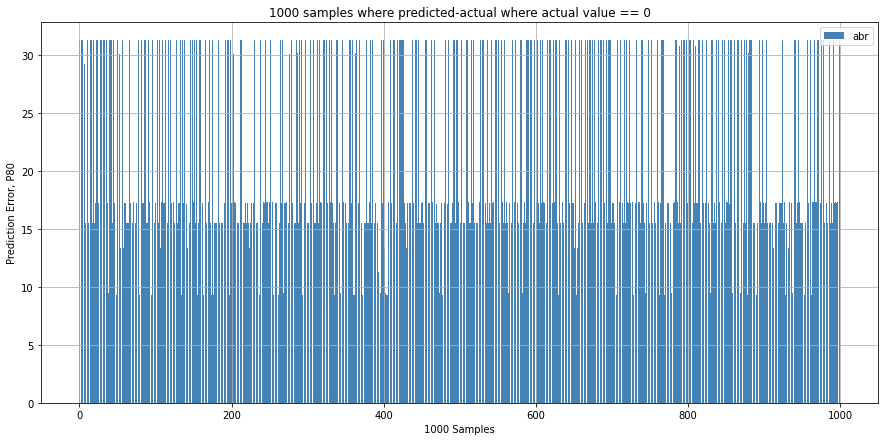

In [103]:
pred_err_plot(model='abr', percentile='P80', n_samples=1000, actual_0=True)

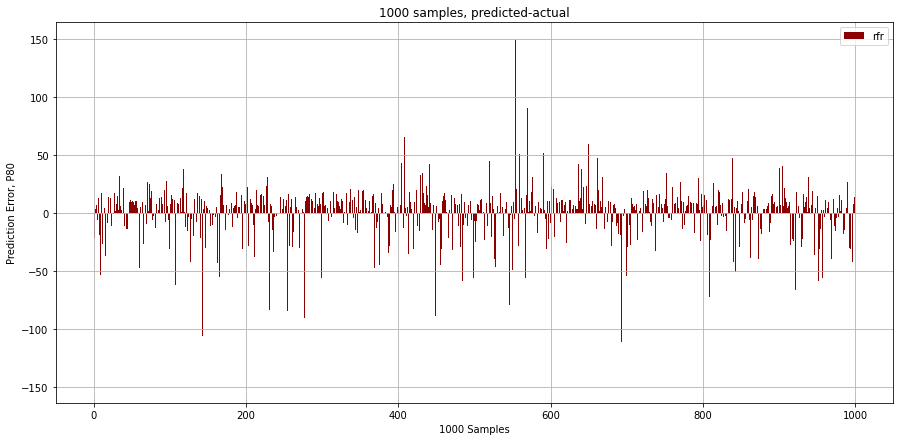

In [104]:
pred_err_plot(model='rfr', percentile='P80', n_samples=1000, color='darkred')

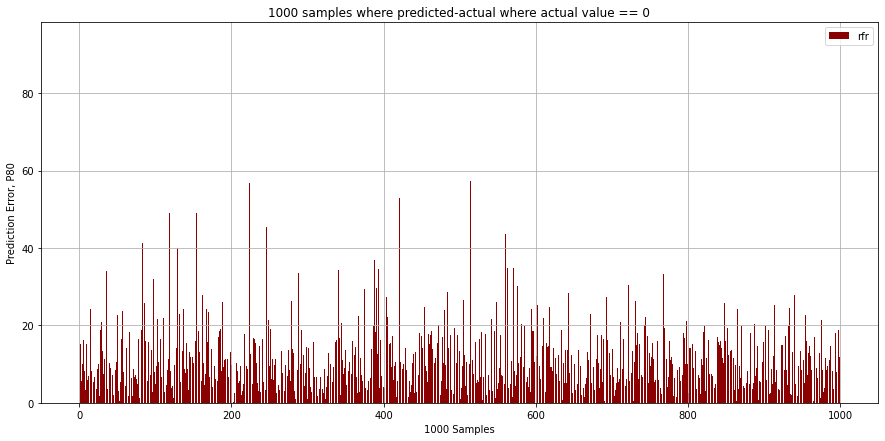

In [105]:
pred_err_plot(model='rfr', percentile='P80', n_samples=1000, actual_0=True, color='darkred')

In [98]:
def raw_pred_plot(model, percentile, n_samples, color='steelblue'):
    perc_dict = {
        'P20': 0,
        'P40': 1,
        'P50': 2,
        'P60': 3,
        'P80': 4
    }
    
    fig,axs = plt.subplots(figsize=(15,7))
    x_ax = np.arange(0, n_samples, 1)

    prediction = pd.DataFrame(preds[model])
    axs.bar(x_ax, 
            prediction[perc_dict[percentile]].sample(n=n_samples), 
            label=model, 
            color=color)

    axs.set_xlabel(f"{n_samples} Samples")
    axs.set_ylabel(f"{percentile} Time Prediction (s)")
    axs.set_title(f"{n_samples} samples of raw predictions")
    axs.grid("on")
    axs.legend()
    plt.show()

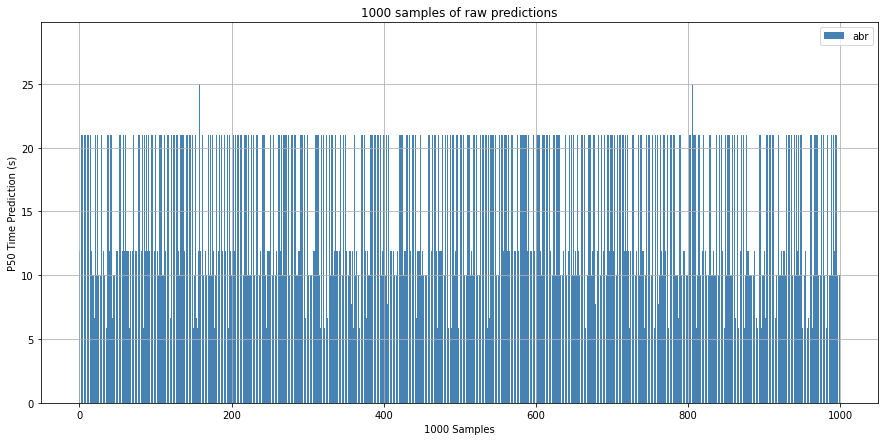

In [99]:
raw_pred_plot(model='abr', percentile='P50', n_samples=1000)

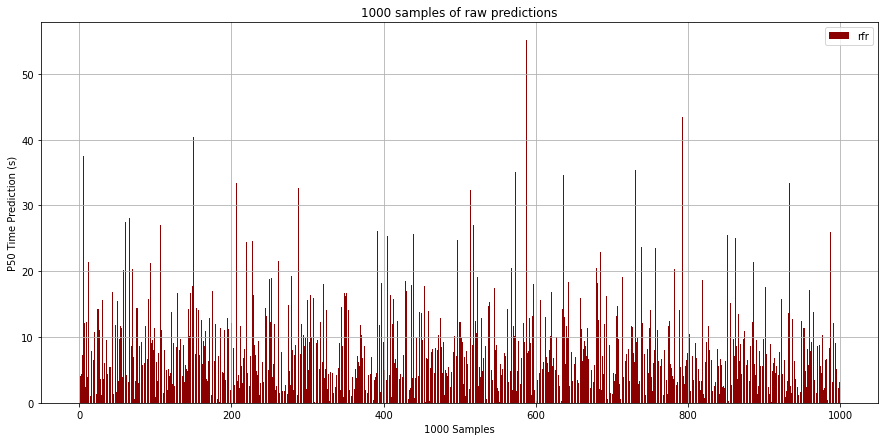

In [100]:
raw_pred_plot(model='rfr', percentile='P50', n_samples=1000, color='darkred')

In [ ]:
# Loading/using stored models
for model in chosen_models:
    load_model = load(f'./model_cache/{model}.joblib')
    preds = load_model['model'].predict(X_test)
    print(mean_squared_error(y_test, preds)**.5)